In [1]:
import pandas as pd
import spotipy
from collections import Counter
import json
import re
from spotipy.exceptions import SpotifyException

Reading all the data via files created from collection stage

In [2]:
with open('token.txt', 'r') as token_file:
    access_token = token_file.read().strip()

sp = spotipy.Spotify(auth=access_token)
user_info = sp.current_user()
username = user_info['id']

In [3]:
csv_name = f"music_data_{username}.csv"
df = pd.read_csv(csv_name)

In [4]:
json_name = f"genres_{username}.json"
with open(json_name,'r') as json_file:
    artist_genres = json.load(json_file)

Reviewing data to ensure smooth access

In [5]:
df.head() 

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Lil Uzi Vert,4O15NlyKLIASxsJ0PrXPfz,2018-10-09 03:22:07+00:00,Multi Millionaire (feat. Lil Uzi Vert),Multi Millionaire (feat. Lil Uzi Vert),single,2024-09-15 06:47:02+00:00,Shardai (Bonus Track),Pink Tape,album,154,133,287
1,Nicki Minaj,0hCNtLu0JehylgoiP8L4Gh,2017-05-07 06:50:29+00:00,Run Up,Run Up,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,40,44,84
2,Drake,3TVXtAsR1Inumwj472S9r4,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,217,68,285
3,Lil Wayne,55Aa2cqylxrFIXC767Z865,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,44,67,111
4,Future,1RyvyyTE3xzB2ZywiAwp0i,2019-01-08 17:12:30+00:00,Fine China,Fine China,single,2024-09-15 06:45:07+00:00,Sir (feat. Future),Queen,album,126,92,218


In [6]:
artist_genres

{'hip hop': ['Lil Uzi Vert',
  'Drake',
  'Lil Wayne',
  'Future',
  'Ty Dolla $ign',
  'Joey Bada$$',
  'A$AP Rocky',
  'J. Cole',
  'Big Sean',
  'Cordae',
  'Anderson .Paak',
  'Migos',
  'Benny The Butcher',
  'Childish Gambino',
  'Mac Miller',
  'Eminem',
  'Ski Mask The Slump God',
  'ScHoolboy Q',
  'Offset',
  'T-Pain',
  'Lupe Fiasco',
  'Chance the Rapper',
  'Snoop Dogg',
  'Kendrick Lamar',
  'Logic',
  'André 3000',
  'Isaiah Rashad',
  'Kid Cudi',
  'Denzel Curry',
  'JID',
  'Chief Keef',
  'Jack Harlow',
  'Lil Durk',
  '21 Savage',
  'YG',
  'Baby Keem',
  'JAY-Z',
  'A$AP Ferg',
  'Danny Brown',
  'Jay Rock',
  '2 Chainz',
  'Missy Elliott',
  'Wiz Khalifa',
  'Diddy',
  'Earl Sweatshirt',
  'The Alchemist',
  'Vince Staples',
  'French Montana',
  'Killer Mike',
  'T.I.',
  'Westside Gunn',
  'Tyler, The Creator',
  'Nas',
  'Freddie Gibbs',
  'NF',
  '50 Cent',
  'Pop Smoke',
  'Ab-Soul',
  'Dreamville',
  "Ol' Dirty Bastard",
  'Rick Ross',
  'DJ Khaled',
  'Kanye

In [7]:
strings_columns = ['artist_name','artist_id','first_song','first_album','first_album_type', 'last_song','last_album','last_album_type']
datetime_columns = ['first_added','last_added']

for string_col in strings_columns:
    df[string_col] = df[string_col].astype(str)

for datetime_col in datetime_columns:
    df[datetime_col] = pd.to_datetime(df[datetime_col])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   artist_name           3798 non-null   object             
 1   artist_id             3798 non-null   object             
 2   first_added           3798 non-null   datetime64[ns, UTC]
 3   first_song            3798 non-null   object             
 4   first_album           3798 non-null   object             
 5   first_album_type      3798 non-null   object             
 6   last_added            3798 non-null   datetime64[ns, UTC]
 7   last_song             3798 non-null   object             
 8   last_album            3798 non-null   object             
 9   last_album_type       3798 non-null   object             
 10  main_songs_count      3798 non-null   int64              
 11  featured_songs_count  3798 non-null   int64              
 12  liked_

In [9]:
df.isnull().values.ravel().sum()

np.int64(0)

First off, before looking at exact artist details, let's look at the user's genres. We need to determine what genres this user has 'listened' to the most. We can cross reference the results of this analysis later when looking at the exact artist details. As all the genres are words, we can start using NLP techniques to determine certain patterns with the genres. 

In [10]:
def normalize_genre_names(genre_list):
    # Step 1: Convert to lowercase
    normalized_genres = [genre.lower() for genre in genre_list]
    
    # Step 2: Replace special characters like dashes, slashes, and underscores with spaces
    normalized_genres = [re.sub(r'[-_/]', ' ', genre) for genre in normalized_genres]
    
    # Step 3: Remove extra spaces
    normalized_genres = [' '.join(genre.split()) for genre in normalized_genres]
    
    # Step 4: Standardize common terms (e.g., abbreviations)
    normalized_genres = [re.sub(r'r&b', 'rnb', genre) for genre in normalized_genres]
    
    # Step 5: Special handling for compound words (e.g., "hip-hop" to "hip hop")
    normalized_genres = [genre.replace('hip hop', 'hip hop') for genre in normalized_genres]
    
    return normalized_genres


In [11]:
all_genres = list(artist_genres.keys())
normalized_genres = normalize_genre_names(all_genres)

In [12]:
def weight_by_word_frequency(strings_list):
    # Concatenate all genre names
    full_text = ' '.join(strings_list)

    # Tokenize words using regex (case insensitive)
    words = re.findall(r'\b[\w&-]+\b', full_text.lower())

    # Count occurrences of each word
    word_counts = Counter(words)

    # Total number of genres
    total_genres = len(strings_list)

    # Calculate weights (frequency of word / total genres)
    word_weights = {word: count / total_genres for word, count in word_counts.items()}

    return word_weights

word_weights = weight_by_word_frequency(normalized_genres)
sorted(word_weights.items(), key=lambda item: item[1], reverse=True)
word_weights


{'hip': 0.10427010923535253,
 'hop': 0.10427010923535253,
 'melodic': 0.005958291956305859,
 'rap': 0.06653426017874876,
 'philly': 0.003972194637537239,
 'rage': 0.0009930486593843098,
 'trap': 0.028798411122144985,
 'pop': 0.13108242303872888,
 'queens': 0.0009930486593843098,
 'canadian': 0.015888778550148957,
 'new': 0.011916583912611719,
 'orleans': 0.0019860973187686196,
 'atl': 0.0029791459781529296,
 'southern': 0.0019860973187686196,
 'contemporary': 0.009930486593843098,
 'rnb': 0.025819265143992055,
 'plugg': 0.0029791459781529296,
 'pluggnb': 0.0009930486593843098,
 'dance': 0.011916583912611719,
 'post': 0.003972194637537239,
 'teen': 0.0019860973187686196,
 'urban': 0.0009930486593843098,
 'glitchcore': 0.0009930486593843098,
 'hyperpop': 0.0029791459781529296,
 'underground': 0.006951340615690168,
 'alt': 0.0009930486593843098,
 'z': 0.0019860973187686196,
 'electropop': 0.004965243296921549,
 'ai': 0.0009930486593843098,
 'art': 0.0019860973187686196,
 'deconstructed': 

In [13]:
def weight_by_artist_prevalence(artist_genres):
    word_artist_count = Counter()
    
    for genre, artists in artist_genres.items():
        # Tokenize the genre name
        words = re.findall(r'\b[\w&-]+\b', genre.lower())
        
        # Increment each word's weight by the number of artists associated with the genre
        for word in words:
            word_artist_count[word] += len(artists)

    return word_artist_count

word_artist_weights = weight_by_artist_prevalence(artist_genres)
word_artist_weights

Counter({'pop': 1372,
         'rap': 973,
         'hip': 954,
         'hop': 936,
         'trap': 561,
         'r&b': 443,
         'indie': 427,
         'latino': 340,
         'alternative': 259,
         'rock': 227,
         'urbano': 224,
         'reggaeton': 212,
         'dance': 193,
         'house': 163,
         'soul': 159,
         'uk': 157,
         'contemporary': 144,
         'modern': 143,
         'latin': 126,
         'z': 123,
         'atl': 99,
         'alt': 98,
         'canadian': 95,
         'edm': 94,
         'singer-songwriter': 94,
         'underground': 92,
         'melodic': 91,
         'emo': 87,
         'sad': 87,
         'cloud': 85,
         'drill': 82,
         'country': 81,
         'southern': 77,
         'flow': 64,
         'electro': 64,
         'pov': 60,
         'lo-fi': 59,
         'dark': 58,
         'electropop': 57,
         'chill': 54,
         'argentino': 52,
         'bedroom': 49,
         'urban': 47,
      

In [14]:
import math

def weight_by_idf(artist_genres):
    N = len(artist_genres)  # Total number of genres
    word_genre_count = Counter()

    # Count how many genres each word appears in
    for genre in artist_genres:
        words = set(re.findall(r'\b[\w&-]+\b', genre.lower()))  # Unique words per genre
        for word in words:
            word_genre_count[word] += 1

    # Calculate IDF for each word
    word_idf = {word: math.log(N / count) for word, count in word_genre_count.items()}

    return word_idf

# Example usage
word_idf_weights = weight_by_idf(artist_genres)
word_idf_weights

{'hip': 2.2607705425610387,
 'hop': 2.2607705425610387,
 'rap': 2.7250761506921366,
 'melodic': 5.122971423490507,
 'philly': 5.528436531598672,
 'rage': 6.914730892718563,
 'trap': 3.547435062732088,
 'pop': 2.1107098479853055,
 'queens': 6.914730892718563,
 'canadian': 4.142142170478781,
 'new': 4.429824242930562,
 'orleans': 6.221583712158617,
 'atl': 5.816118604050453,
 'southern': 6.221583712158617,
 'contemporary': 4.612145799724517,
 'r&b': 3.6566343546970805,
 'plugg': 5.816118604050453,
 'pluggnb': 6.914730892718563,
 'dance': 4.516835619920192,
 'post-teen': 6.914730892718563,
 'urban': 6.914730892718563,
 'glitchcore': 6.914730892718563,
 'hyperpop': 6.221583712158617,
 'underground': 4.968820743663249,
 'alt': 6.914730892718563,
 'z': 6.221583712158617,
 'electropop': 5.305292980284462,
 'ai': 6.914730892718563,
 'art': 6.221583712158617,
 'deconstructed': 6.914730892718563,
 'club': 6.221583712158617,
 'escape': 6.914730892718563,
 'room': 5.528436531598672,
 'experimental

In [15]:
def combine_weights(frequency_weights, idf_weights, alpha=0.5):
    combined_weights = {}
    
    for word in frequency_weights:
        combined_weights[word] = alpha * frequency_weights[word] + (1 - alpha) * idf_weights.get(word, 0)
    
    return combined_weights

# Example usage
combined_weights = combine_weights(word_weights, word_idf_weights)
combined_weights

{'hip': 1.1825203258981956,
 'hop': 1.1825203258981956,
 'melodic': 2.5644648577234066,
 'rap': 1.3958052054354426,
 'philly': 2.7662043631181046,
 'rage': 3.4578619706889735,
 'trap': 1.7881167369271165,
 'pop': 1.1208961355120173,
 'queens': 3.4578619706889735,
 'canadian': 2.079015474514465,
 'new': 2.220870413421587,
 'orleans': 3.111784904738693,
 'atl': 2.909548875014303,
 'southern': 3.111784904738693,
 'contemporary': 2.31103814315918,
 'rnb': 0.012909632571996028,
 'plugg': 2.909548875014303,
 'pluggnb': 3.4578619706889735,
 'dance': 2.264376101916402,
 'post': 0.0019860973187686196,
 'teen': 3.4583584950186657,
 'urban': 3.4578619706889735,
 'glitchcore': 3.4578619706889735,
 'hyperpop': 3.112281429068385,
 'underground': 2.4878860421394697,
 'alt': 3.4578619706889735,
 'z': 3.111784904738693,
 'electropop': 2.655129111790692,
 'ai': 3.4578619706889735,
 'art': 3.111784904738693,
 'deconstructed': 3.4578619706889735,
 'club': 3.111784904738693,
 'escape': 3.4578619706889735,


In [16]:
sorted(combined_weights.items(), key=lambda item : item[1], reverse=True)

[('teen', 3.4583584950186657),
 ('grunge', 3.4583584950186657),
 ('anthem', 3.4583584950186657),
 ('screamo', 3.4583584950186657),
 ('rage', 3.4578619706889735),
 ('queens', 3.4578619706889735),
 ('pluggnb', 3.4578619706889735),
 ('urban', 3.4578619706889735),
 ('glitchcore', 3.4578619706889735),
 ('alt', 3.4578619706889735),
 ('ai', 3.4578619706889735),
 ('deconstructed', 3.4578619706889735),
 ('escape', 3.4578619706889735),
 ('fluxwork', 3.4578619706889735),
 ('latina', 3.4578619706889735),
 ('conscious', 3.4578619706889735),
 ('afrofuturism', 3.4578619706889735),
 ('trip', 3.4578619706889735),
 ('candy', 3.4578619706889735),
 ('metropopolis', 3.4578619706889735),
 ('stutter', 3.4578619706889735),
 ('derry', 3.4578619706889735),
 ('north', 3.4578619706889735),
 ('gangster', 3.4578619706889735),
 ('chillwave', 3.4578619706889735),
 ('hypnagogic', 3.4578619706889735),
 ('indietronica', 3.4578619706889735),
 ('slap', 3.4578619706889735),
 ('social', 3.4578619706889735),
 ('media', 3.457

In [17]:
weight_count = {}
for weight in combined_weights.values():
    if weight not in weight_count:
        weight_count[weight] = 1
    else:
        weight_count[weight] += 1

[]

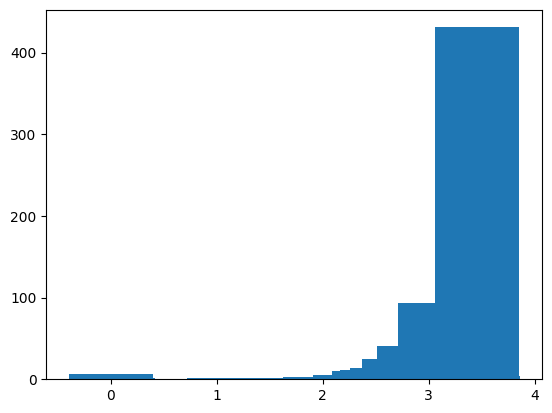

In [18]:
import matplotlib.pyplot as plt
plt.bar(x=weight_count.keys(), height=weight_count.values())
plt.plot()

Genres with high combined scores are more specific to that artist (frequent for that artist and rare across others).
Genres with low combined scores are less relevant, either because they’re used less frequently for that artist or because they’re too common across many artists.

In [19]:
threshold = 3
above_threshold_keys = [key for key, value in combined_weights.items() if value >= threshold]
below_threshold_keys = [key for key, value in combined_weights.items() if value < threshold]

print("Keys with values above the threshold:", above_threshold_keys)
print("Keys with values below the threshold:", below_threshold_keys)

Keys with values above the threshold: ['rage', 'queens', 'orleans', 'southern', 'pluggnb', 'teen', 'urban', 'glitchcore', 'hyperpop', 'alt', 'z', 'ai', 'art', 'deconstructed', 'club', 'escape', 'fluxwork', 'latina', 'conscious', 'colombian', 'colombiano', 'afrofuturism', 'trip', 'candy', 'metropopolis', 'stutter', 'derry', 'east', 'north', 'carolina', 'gangster', 'chillwave', 'hypnagogic', 'indietronica', 'detroit', 'brooklyn', 'slap', 'social', 'media', 'bubblegrunge', 'pov', 'corecore', 'rj', 'baiano', 'nacional', 'dreamo', 'grunge', 'spacegrunge', 'zoomergaze', 'afrobeats', 'nigerian', 'toronto', 'buffalo', 'upstate', 'ny', 'socal', 'boy', 'band', 'la', 'dembow', 'amapiano', 'kentucky', 'pittsburgh', 'downtempo', 'shiver', 'complextro', 'anthem', 'cali', 'cantautora', 'mexicana', 'westcoast', 'afropop', 'tennessee', 'emoplugg', 'ohio', 'meme', 'tech', 'boricua', 'scam', 'quiet', 'storm', 'girl', 'beats', 'wonky', 'florida', 'miami', 'alabama', 'virginia', 'funktronica', 'conciencia'

In [20]:
relevant_details = {}
for genre, artists in artist_genres.items():
    if any(substring in genre for substring in below_threshold_keys):
        relevant_details[genre] = set()
        relevant_details[genre].update(artists)
    

In [21]:
relevant_details

{'hip hop': {'2 Chainz',
  '21 Savage',
  '2Pac',
  '50 Cent',
  '9th Wonder',
  'A$AP Ferg',
  'A$AP Mob',
  'A$AP Rocky',
  'Ab-Soul',
  'Action Bronson',
  'Anderson .Paak',
  'André 3000',
  'Baby Keem',
  'Benny The Butcher',
  'Big Boi',
  'Big Sean',
  'Bone Thugs-N-Harmony',
  'Busta Rhymes',
  'Chance the Rapper',
  'Chief Keef',
  'Childish Gambino',
  'Clipse',
  'Common',
  'Cordae',
  'DJ Khaled',
  'DaBaby',
  'Danny Brown',
  'Denzel Curry',
  'Diddy',
  'Dr. Dre',
  'Drake',
  'Dreamville',
  'Earl Sweatshirt',
  'Eazy-E',
  'Eminem',
  'Fabolous',
  'Fat Joe',
  'Freddie Gibbs',
  'French Montana',
  'Future',
  'Gucci Mane',
  'Ice Cube',
  'Isaiah Rashad',
  'J. Cole',
  'JAY-Z',
  'JID',
  'Jack Harlow',
  'Jay Electronica',
  'Jay Rock',
  'Joey Bada$$',
  'Joyner Lucas',
  'Kanye West',
  'Kendrick Lamar',
  'Kid Cudi',
  'Killer Mike',
  'Lil Durk',
  'Lil Uzi Vert',
  'Lil Wayne',
  'Logic',
  'Ludacris',
  'Lupe Fiasco',
  'MF DOOM',
  'Mac Miller',
  'Madlib',

In [22]:
remaining_genres = set(artist_genres.keys()) - set(relevant_details.keys())
remaining_artists = set(frozenset(artists) for artists in artist_genres.values()) - set(frozenset(artists) for artists in relevant_details.values())

In [23]:
main_artists = set.union(*relevant_details.values())

Now we have the most relevant artist and genres for this user. Using this, let's look into the exact artist details and cross reference the results.

In [24]:
# df.loc[:, 'diff_of_added_time'] = df['last_added'] - df['first_added']
relevant_artists_df = df[df['artist_name'].isin(main_artists)].reset_index(drop=True)
relevant_artists_df.head()

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Lil Uzi Vert,4O15NlyKLIASxsJ0PrXPfz,2018-10-09 03:22:07+00:00,Multi Millionaire (feat. Lil Uzi Vert),Multi Millionaire (feat. Lil Uzi Vert),single,2024-09-15 06:47:02+00:00,Shardai (Bonus Track),Pink Tape,album,154,133,287
1,Nicki Minaj,0hCNtLu0JehylgoiP8L4Gh,2017-05-07 06:50:29+00:00,Run Up,Run Up,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,40,44,84
2,Drake,3TVXtAsR1Inumwj472S9r4,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,217,68,285
3,Lil Wayne,55Aa2cqylxrFIXC767Z865,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,44,67,111
4,Future,1RyvyyTE3xzB2ZywiAwp0i,2019-01-08 17:12:30+00:00,Fine China,Fine China,single,2024-09-15 06:45:07+00:00,Sir (feat. Future),Queen,album,126,92,218


In [25]:
flattened_remaining_artists = set(artist for artists in remaining_artists for artist in artists) - main_artists
irelevant_artists_df = df[df['artist_name'].isin(flattened_remaining_artists)].reset_index(drop=True)
irelevant_artists_df.head()

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Jhené Aiko,5ZS223C6JyBfXasXxrRqOk,2019-09-04 07:31:50+00:00,Worthy,Late Nights: The Album,album,2024-08-09 04:39:23+00:00,guidance,guidance,single,77,26,103
1,Souloho,3hBV3vYyb4kAxFfCevJjjg,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,1,0,1
2,Giveon,4fxd5Ee7UefO4CUXgwJ7IP,2020-05-01 04:03:28+00:00,Chicago Freestyle (feat. Giveon),Dark Lane Demo Tapes,album,2024-06-01 03:15:54+00:00,Last Heartbreak Song (feat. Giveon),The Year I Turned 21,album,22,4,26
3,EKKSTACY,0ynzbXwyCzxicMKHBoOkSH,2021-04-16 04:19:52+00:00,i want to be by your side,i want to be by your side (feat. herhexx),single,2024-01-19 12:24:31+00:00,alright (feat. The Kid LAROI),EKKSTACY,album,9,1,10
4,Lauren Jauregui,3J0BpFVUc9LeOIVeN5uNhU,2020-02-21 05:05:15+00:00,NADA (with Lauren Jauregui & C. Tangana),NADA (with Lauren Jauregui & C. Tangana),single,2023-05-26 17:46:06+00:00,Wolves (feat. Ty Dolla $ign & Russ),In Between,album,9,5,14


Now we have seperated main artists and artists that we may not need but lets anlayze both these sets a bit further.
One main thing to account for this data is that some artists here may only have a few songs. The average amount of the smallest project an artist releases (an ep) is 6 so we can going to determine what artists fit the criteria.

In [26]:
relevant_artists_small_num_song_df = relevant_artists_df[relevant_artists_df['liked_songs_count'] <= 6]
relevant_artists_huge_num_song_df = relevant_artists_df[relevant_artists_df['liked_songs_count'] > 6]

irelevant_artists_small_num_song_df = irelevant_artists_df[irelevant_artists_df['liked_songs_count'] <= 6]
irelevant_artists_huge_num_song_df = irelevant_artists_df[irelevant_artists_df['liked_songs_count'] > 6]

In [27]:
len(relevant_artists_small_num_song_df)

2285

In [28]:
len(relevant_artists_huge_num_song_df)

655

In [29]:
len(irelevant_artists_small_num_song_df)

19

In [30]:
len(irelevant_artists_huge_num_song_df)

4

In [31]:
import datetime

current_year = datetime.datetime.now().year

relevant_artists_small_num_song_df_keep = relevant_artists_small_num_song_df[
    ((relevant_artists_small_num_song_df['last_added'].dt.year == current_year) | (relevant_artists_small_num_song_df['last_added'].dt.year == current_year - 1))
]

relevant_artists_small_num_song_df_store = relevant_artists_small_num_song_df.drop(relevant_artists_small_num_song_df_keep.index)

relevant_artists_small_num_song_df_keep

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
9,Jordin Sparks,2AQjGvtT0pFYfxR3neFcvz,2021-06-08 06:32:05+00:00,Count On You (feat. Jordin Sparks),BTR,album,2024-09-13 04:03:12+00:00,More Than Enough!,More Than Enough!,single,1,2,3
15,Arca,4SQdUpG4f7UbkJG3cJ2Iyj,2020-06-26 04:36:55+00:00,KLK,KLK,single,2024-09-13 04:01:25+00:00,Chama,Chama,single,5,1,6
16,Tokischa,2p4aN0Uxkk3iT3HK0cJ2cJ,2021-09-03 04:01:55+00:00,Linda,Linda,single,2024-09-13 04:01:25+00:00,Chama,Chama,single,1,4,5
19,Terrace Martin,7MNEVabc4cs19CbzAFZmXz,2021-05-06 19:00:36+00:00,Freeze Tag (feat. Cordae & Phoelix),Dinner Party: Dessert,album,2024-09-13 04:01:20+00:00,Read the Room,Nintindo Soul,album,3,0,3
33,SOAK,4PLsMEk2DCRVlVL2a9aZAv,2024-09-13 03:36:33+00:00,just stand there,ten days,album,2024-09-13 03:36:33+00:00,just stand there,ten days,album,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,Pailita,4yxLYO2imECxGYTTV7RQKb,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,1,0,1
916,Cris Mj,1Yj5Xey7kTwvZla8sqdsdE,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,0,1,1
917,Avelino,039zhJoEkboZ8Ii6K40Fb6,2023-01-02 03:25:10+00:00,2 Certified,2 Certified,single,2023-01-02 03:25:10+00:00,2 Certified,2 Certified,single,0,1,1
918,Laura Marano,21mgsWjJ4TmBxsUKexjJPT,2022-12-29 01:14:48+00:00,I Love Christmas,I Love Christmas,single,2023-01-02 03:20:45+00:00,BAD TIME GOOD TIME,BAD TIME GOOD TIME,single,1,1,2


In [32]:
irelevant_artists_small_num_song_df_keep = irelevant_artists_small_num_song_df[
    ((irelevant_artists_small_num_song_df['last_added'].dt.year == current_year) | (irelevant_artists_small_num_song_df['last_added'].dt.year == current_year - 1))
]
irelevant_artists_small_num_song_df_keep 

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
1,Souloho,3hBV3vYyb4kAxFfCevJjjg,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,1,0,1
5,Jasiel Nuñez,0T8Ix53aIN4F7aEKj4EnKy,2023-04-21 04:05:49+00:00,Rosa Pastel,Rosa Pastel,single,2023-04-21 04:05:49+00:00,Rosa Pastel,Rosa Pastel,single,0,1,1
6,Chloe x Halle,0AsThoR4KZSVktALiNcQwW,2020-04-17 04:11:24+00:00,Catch Up (feat. Mike WiLL Made-It),Catch Up (feat. Mike WiLL Made-It),single,2023-01-16 22:06:46+00:00,Unstoppable,Austin & Ally: Turn It Up (Soundtrack from the...,compilation,5,0,5


In [33]:
relevant_artists_huge_num_song_df = relevant_artists_df[relevant_artists_df['liked_songs_count'] > 6]
irelevant_artists_huge_num_song_df = irelevant_artists_df[irelevant_artists_df['liked_songs_count'] > 6]

In [34]:
relevant_artists_huge_num_song_df

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Lil Uzi Vert,4O15NlyKLIASxsJ0PrXPfz,2018-10-09 03:22:07+00:00,Multi Millionaire (feat. Lil Uzi Vert),Multi Millionaire (feat. Lil Uzi Vert),single,2024-09-15 06:47:02+00:00,Shardai (Bonus Track),Pink Tape,album,154,133,287
1,Nicki Minaj,0hCNtLu0JehylgoiP8L4Gh,2017-05-07 06:50:29+00:00,Run Up,Run Up,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,40,44,84
2,Drake,3TVXtAsR1Inumwj472S9r4,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,217,68,285
3,Lil Wayne,55Aa2cqylxrFIXC767Z865,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,44,67,111
4,Future,1RyvyyTE3xzB2ZywiAwp0i,2019-01-08 17:12:30+00:00,Fine China,Fine China,single,2024-09-15 06:45:07+00:00,Sir (feat. Future),Queen,album,126,92,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,Jon Bellion,50JJSqHUf2RQ9xsHs0KMHg,2018-10-18 02:43:25+00:00,All Time Low,The Human Condition,album,2020-05-19 17:29:05+00:00,Good Things Fall Apart (with Jon Bellion) [Tra...,ASCEND (Remixes),album,14,3,17
2624,Lil Raven,3lVqIkYlSwyv22KJKHvW8t,2019-09-06 06:23:27+00:00,FREAK A LEAK,FLY DIARIES,album,2020-03-28 07:01:35+00:00,Fuck You Mean,Fly Away,single,10,2,12
2639,Hella Sketchy,56SqyTjGTjAIkbvjidFEku,2019-08-01 21:24:56+00:00,Heart Emojis,Hella Sketchy,album,2020-03-06 05:10:57+00:00,No Chic Fil A,No Chic Fil A,single,15,0,15
2647,Liam Payne,5pUo3fmmHT8bhCyHE52hA6,2017-09-06 23:54:06+00:00,Strip That Down,Strip That Down,single,2020-02-06 03:03:57+00:00,Polaroid (With Jonas Blue & Lennon Stella),LP1,album,7,2,9


In [35]:
relevant_artists_huge_num_song_df_keep = relevant_artists_huge_num_song_df[
    ((relevant_artists_huge_num_song_df['last_added'].dt.year == current_year) | (relevant_artists_huge_num_song_df['last_added'].dt.year == current_year - 1))
]
relevant_artists_huge_num_song_df_keep 

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Lil Uzi Vert,4O15NlyKLIASxsJ0PrXPfz,2018-10-09 03:22:07+00:00,Multi Millionaire (feat. Lil Uzi Vert),Multi Millionaire (feat. Lil Uzi Vert),single,2024-09-15 06:47:02+00:00,Shardai (Bonus Track),Pink Tape,album,154,133,287
1,Nicki Minaj,0hCNtLu0JehylgoiP8L4Gh,2017-05-07 06:50:29+00:00,Run Up,Run Up,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,40,44,84
2,Drake,3TVXtAsR1Inumwj472S9r4,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,217,68,285
3,Lil Wayne,55Aa2cqylxrFIXC767Z865,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,44,67,111
4,Future,1RyvyyTE3xzB2ZywiAwp0i,2019-01-08 17:12:30+00:00,Fine China,Fine China,single,2024-09-15 06:45:07+00:00,Sir (feat. Future),Queen,album,126,92,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,2017-03-31 19:54:22+00:00,Shape of You,Shape of You,single,2023-02-01 03:42:06+00:00,Who We Love (feat. Ed Sheeran),Gloria,album,29,14,43
883,Pouya,4nXOZlYoAD67hF9aUEncMY,2019-10-18 04:09:07+00:00,That's My Baby (feat. Pouya),That's My Baby (feat. Pouya),single,2023-01-20 05:01:56+00:00,Seen It All Before,Seen It All Before,single,21,19,40
888,Oliver Francis,0WvTK38rXqPCD5pZMDuX20,2020-06-26 05:07:40+00:00,Comfortable,Chlorine,album,2023-01-20 05:01:14+00:00,tight rope,pond scum ~ b sides,single,26,0,26
892,Moneybagg Yo,3tJoFztHeIJkJWMrx0td2f,2019-08-01 21:24:54+00:00,Bank,Harder Than Ever,album,2023-01-15 05:02:57+00:00,On Wat U On (with GloRilla),On Wat U On (with GloRilla),single,10,15,25


In [36]:
irelevant_artists_huge_num_song_df

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Jhené Aiko,5ZS223C6JyBfXasXxrRqOk,2019-09-04 07:31:50+00:00,Worthy,Late Nights: The Album,album,2024-08-09 04:39:23+00:00,guidance,guidance,single,77,26,103
2,Giveon,4fxd5Ee7UefO4CUXgwJ7IP,2020-05-01 04:03:28+00:00,Chicago Freestyle (feat. Giveon),Dark Lane Demo Tapes,album,2024-06-01 03:15:54+00:00,Last Heartbreak Song (feat. Giveon),The Year I Turned 21,album,22,4,26
3,EKKSTACY,0ynzbXwyCzxicMKHBoOkSH,2021-04-16 04:19:52+00:00,i want to be by your side,i want to be by your side (feat. herhexx),single,2024-01-19 12:24:31+00:00,alright (feat. The Kid LAROI),EKKSTACY,album,9,1,10
4,Lauren Jauregui,3J0BpFVUc9LeOIVeN5uNhU,2020-02-21 05:05:15+00:00,NADA (with Lauren Jauregui & C. Tangana),NADA (with Lauren Jauregui & C. Tangana),single,2023-05-26 17:46:06+00:00,Wolves (feat. Ty Dolla $ign & Russ),In Between,album,9,5,14


In [37]:
irelevant_artists_huge_num_song_df_keep = irelevant_artists_huge_num_song_df[
    ((irelevant_artists_huge_num_song_df['last_added'].dt.year == current_year) | (irelevant_artists_huge_num_song_df['last_added'].dt.year == current_year - 1))
]
irelevant_artists_huge_num_song_df_keep 

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Jhené Aiko,5ZS223C6JyBfXasXxrRqOk,2019-09-04 07:31:50+00:00,Worthy,Late Nights: The Album,album,2024-08-09 04:39:23+00:00,guidance,guidance,single,77,26,103
2,Giveon,4fxd5Ee7UefO4CUXgwJ7IP,2020-05-01 04:03:28+00:00,Chicago Freestyle (feat. Giveon),Dark Lane Demo Tapes,album,2024-06-01 03:15:54+00:00,Last Heartbreak Song (feat. Giveon),The Year I Turned 21,album,22,4,26
3,EKKSTACY,0ynzbXwyCzxicMKHBoOkSH,2021-04-16 04:19:52+00:00,i want to be by your side,i want to be by your side (feat. herhexx),single,2024-01-19 12:24:31+00:00,alright (feat. The Kid LAROI),EKKSTACY,album,9,1,10
4,Lauren Jauregui,3J0BpFVUc9LeOIVeN5uNhU,2020-02-21 05:05:15+00:00,NADA (with Lauren Jauregui & C. Tangana),NADA (with Lauren Jauregui & C. Tangana),single,2023-05-26 17:46:06+00:00,Wolves (feat. Ty Dolla $ign & Russ),In Between,album,9,5,14


In [38]:
irelevant_artists_huge_num_song_df_keep

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Jhené Aiko,5ZS223C6JyBfXasXxrRqOk,2019-09-04 07:31:50+00:00,Worthy,Late Nights: The Album,album,2024-08-09 04:39:23+00:00,guidance,guidance,single,77,26,103
2,Giveon,4fxd5Ee7UefO4CUXgwJ7IP,2020-05-01 04:03:28+00:00,Chicago Freestyle (feat. Giveon),Dark Lane Demo Tapes,album,2024-06-01 03:15:54+00:00,Last Heartbreak Song (feat. Giveon),The Year I Turned 21,album,22,4,26
3,EKKSTACY,0ynzbXwyCzxicMKHBoOkSH,2021-04-16 04:19:52+00:00,i want to be by your side,i want to be by your side (feat. herhexx),single,2024-01-19 12:24:31+00:00,alright (feat. The Kid LAROI),EKKSTACY,album,9,1,10
4,Lauren Jauregui,3J0BpFVUc9LeOIVeN5uNhU,2020-02-21 05:05:15+00:00,NADA (with Lauren Jauregui & C. Tangana),NADA (with Lauren Jauregui & C. Tangana),single,2023-05-26 17:46:06+00:00,Wolves (feat. Ty Dolla $ign & Russ),In Between,album,9,5,14


In [39]:
irelevant_artists_small_num_song_df_keep

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
1,Souloho,3hBV3vYyb4kAxFfCevJjjg,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,1,0,1
5,Jasiel Nuñez,0T8Ix53aIN4F7aEKj4EnKy,2023-04-21 04:05:49+00:00,Rosa Pastel,Rosa Pastel,single,2023-04-21 04:05:49+00:00,Rosa Pastel,Rosa Pastel,single,0,1,1
6,Chloe x Halle,0AsThoR4KZSVktALiNcQwW,2020-04-17 04:11:24+00:00,Catch Up (feat. Mike WiLL Made-It),Catch Up (feat. Mike WiLL Made-It),single,2023-01-16 22:06:46+00:00,Unstoppable,Austin & Ally: Turn It Up (Soundtrack from the...,compilation,5,0,5


In [40]:
irelevant_artists_final_df = pd.concat([irelevant_artists_huge_num_song_df_keep, irelevant_artists_small_num_song_df_keep],ignore_index=True)
irelevant_artists_final_df

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Jhené Aiko,5ZS223C6JyBfXasXxrRqOk,2019-09-04 07:31:50+00:00,Worthy,Late Nights: The Album,album,2024-08-09 04:39:23+00:00,guidance,guidance,single,77,26,103
1,Giveon,4fxd5Ee7UefO4CUXgwJ7IP,2020-05-01 04:03:28+00:00,Chicago Freestyle (feat. Giveon),Dark Lane Demo Tapes,album,2024-06-01 03:15:54+00:00,Last Heartbreak Song (feat. Giveon),The Year I Turned 21,album,22,4,26
2,EKKSTACY,0ynzbXwyCzxicMKHBoOkSH,2021-04-16 04:19:52+00:00,i want to be by your side,i want to be by your side (feat. herhexx),single,2024-01-19 12:24:31+00:00,alright (feat. The Kid LAROI),EKKSTACY,album,9,1,10
3,Lauren Jauregui,3J0BpFVUc9LeOIVeN5uNhU,2020-02-21 05:05:15+00:00,NADA (with Lauren Jauregui & C. Tangana),NADA (with Lauren Jauregui & C. Tangana),single,2023-05-26 17:46:06+00:00,Wolves (feat. Ty Dolla $ign & Russ),In Between,album,9,5,14
4,Souloho,3hBV3vYyb4kAxFfCevJjjg,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,2024-08-09 04:37:53+00:00,Forbidden Love,Forbidden Love,single,1,0,1
5,Jasiel Nuñez,0T8Ix53aIN4F7aEKj4EnKy,2023-04-21 04:05:49+00:00,Rosa Pastel,Rosa Pastel,single,2023-04-21 04:05:49+00:00,Rosa Pastel,Rosa Pastel,single,0,1,1
6,Chloe x Halle,0AsThoR4KZSVktALiNcQwW,2020-04-17 04:11:24+00:00,Catch Up (feat. Mike WiLL Made-It),Catch Up (feat. Mike WiLL Made-It),single,2023-01-16 22:06:46+00:00,Unstoppable,Austin & Ally: Turn It Up (Soundtrack from the...,compilation,5,0,5


In [41]:
relevant_artists_final_df = pd.concat([relevant_artists_huge_num_song_df_keep, relevant_artists_small_num_song_df_keep], ignore_index=True)
relevant_artists_final_df

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
0,Lil Uzi Vert,4O15NlyKLIASxsJ0PrXPfz,2018-10-09 03:22:07+00:00,Multi Millionaire (feat. Lil Uzi Vert),Multi Millionaire (feat. Lil Uzi Vert),single,2024-09-15 06:47:02+00:00,Shardai (Bonus Track),Pink Tape,album,154,133,287
1,Nicki Minaj,0hCNtLu0JehylgoiP8L4Gh,2017-05-07 06:50:29+00:00,Run Up,Run Up,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,40,44,84
2,Drake,3TVXtAsR1Inumwj472S9r4,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,217,68,285
3,Lil Wayne,55Aa2cqylxrFIXC767Z865,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,44,67,111
4,Future,1RyvyyTE3xzB2ZywiAwp0i,2019-01-08 17:12:30+00:00,Fine China,Fine China,single,2024-09-15 06:45:07+00:00,Sir (feat. Future),Queen,album,126,92,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,Pailita,4yxLYO2imECxGYTTV7RQKb,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,1,0,1
916,Cris Mj,1Yj5Xey7kTwvZla8sqdsdE,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,2023-01-02 03:28:42+00:00,Llamame Bebe,Llamame Bebe,single,0,1,1
917,Avelino,039zhJoEkboZ8Ii6K40Fb6,2023-01-02 03:25:10+00:00,2 Certified,2 Certified,single,2023-01-02 03:25:10+00:00,2 Certified,2 Certified,single,0,1,1
918,Laura Marano,21mgsWjJ4TmBxsUKexjJPT,2022-12-29 01:14:48+00:00,I Love Christmas,I Love Christmas,single,2023-01-02 03:20:45+00:00,BAD TIME GOOD TIME,BAD TIME GOOD TIME,single,1,1,2


In [42]:
final_df = pd.concat([relevant_artists_final_df, irelevant_artists_final_df],ignore_index=True)
final_df = final_df.sort_values(['liked_songs_count'],ascending=False)
final_df

,artist_name,artist_id,first_added,first_song,first_album,first_album_type,last_added,last_song,last_album,last_album_type,main_songs_count,featured_songs_count,liked_songs_count
36,Juice WRLD,4MCBfE4596Uoi2O4DtmEMz,2018-07-20 18:58:32+00:00,All Girls Are The Same,Goodbye & Good Riddance,album,2024-09-09 16:53:36+00:00,Lightyears (with Young Thug),The Pre-Party,single,231,65,296
0,Lil Uzi Vert,4O15NlyKLIASxsJ0PrXPfz,2018-10-09 03:22:07+00:00,Multi Millionaire (feat. Lil Uzi Vert),Multi Millionaire (feat. Lil Uzi Vert),single,2024-09-15 06:47:02+00:00,Shardai (Bonus Track),Pink Tape,album,154,133,287
2,Drake,3TVXtAsR1Inumwj472S9r4,2017-05-07 06:55:21+00:00,No Frauds,No Frauds,single,2024-09-15 06:45:25+00:00,Seeing Green (with Drake & Lil Wayne),Beam Me Up Scotty,album,217,68,285
4,Future,1RyvyyTE3xzB2ZywiAwp0i,2019-01-08 17:12:30+00:00,Fine China,Fine China,single,2024-09-15 06:45:07+00:00,Sir (feat. Future),Queen,album,126,92,218
45,Travis Scott,0Y5tJX1MQlPlqiwlOH1tJY,2017-06-09 10:46:39+00:00,Know No Better,Know No Better,single,2024-08-30 04:27:07+00:00,CR@SH (feat. Travis Scott),ALL TIME HIGH,album,90,125,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,Kim Loaiza,1QivQCLVipV61DiQiyV14A,2023-04-21 04:07:53+00:00,Kitty,Kitty,single,2023-04-21 04:07:53+00:00,Kitty,Kitty,single,1,0,1
777,BigXthaPlug,6qxpnaukVayrQn6ViNvu9I,2023-04-21 04:07:19+00:00,OFF THE PORCH (feat. BigXthaPlug & Maxo Kream),OFF THE PORCH (feat. BigXthaPlug & Maxo Kream),single,2023-04-21 04:07:19+00:00,OFF THE PORCH (feat. BigXthaPlug & Maxo Kream),OFF THE PORCH (feat. BigXthaPlug & Maxo Kream),single,0,1,1
485,Lay Bankz,4OVbrPbhvK46A1uXTU1u5F,2024-06-22 17:15:29+00:00,AND DID,Freshman Grad.,single,2024-06-22 17:15:29+00:00,AND DID,Freshman Grad.,single,1,0,1
780,Bree Runway,58hqTaCiqGrMsNmmm3qL7w,2023-04-21 04:05:47+00:00,Be The One (with Khalid),Be The One (with Khalid),single,2023-04-21 04:05:47+00:00,Be The One (with Khalid),Be The One (with Khalid),single,1,0,1


In [43]:
do_not_consider_artists = pd.concat([df, final_df]).drop_duplicates(keep=False)
do_not_consider_artists = set(do_not_consider_artists['artist_name'])
do_not_consider_artists

{'Bizzy Banks',
 'Mann',
 'Einer Bankz',
 'Maya Hawke',
 'carolesdaughter',
 'Kingna Scott',
 'The Isley Brothers',
 'Alec King',
 'Valley Boy',
 'payton',
 'City Morgue',
 'Musicologo The Libro',
 'Pablo Alborán',
 'Wilkinson',
 'ELLIANA',
 'Jace',
 'Chris Andrew',
 'Aiyana-Lee',
 'BigHead',
 'D33J',
 'Samara Joy',
 'Marvel',
 'Dagny',
 'Bslime',
 'Daniel Skye',
 'Yo Trane',
 'Chrissie Fit',
 'guccihighwaters',
 'D.OZi',
 'Leon Bridges',
 'Jason Derulo',
 'Ayme',
 'Riff 3x',
 'Bow Anderson',
 'Ha*Ash',
 'Sjava',
 'Marcianos Crew',
 'ABRA',
 'Lil Pump',
 'Jessica Jarrell',
 'DJ Nelson',
 'DEKKO',
 'CJ',
 'Joel Corry',
 'Bootsy Collins',
 'Ben Böhmer',
 'Ethereal',
 'Crystal Skies',
 'Tommy Torres',
 'Trilla Kid',
 'BANKS',
 'Malz Monday',
 'María Isabel',
 'King Promise',
 'Cool & Dre',
 'Raphael Futura',
 'Leeks',
 'Salda',
 'Fat Nwigwe',
 '!llmind',
 'Joe Fox',
 'Steel Banglez',
 'Miraa May',
 'WILHELM',
 'Jesse Baez',
 'Shaun Ross',
 'Randolph',
 'Clara Mae',
 'Toian',
 'Big Soto',


In [ ]:
sp.artist_related_artists()